**Resnet-18**

In [4]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import os
import zipfile
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torchvision import models
import time

In [ ]:
files.upload()

In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d mcagriaksoy/trees-in-satellite-imagery

Dataset URL: https://www.kaggle.com/datasets/mcagriaksoy/trees-in-satellite-imagery
License(s): CC-BY-NC-SA-4.0


In [8]:
# Unzip the dataset
with zipfile.ZipFile("trees-in-satellite-imagery.zip", "r") as zip_ref:
    zip_ref.extractall("trees_dataset")

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [9]:
# Define transformations (resize, normalize, augment)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Slight shift
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset path
dataset_path = "trees_dataset/Trees in Satellite Imagery"

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Check class labels
print("Class Mapping:", dataset.class_to_idx)  # {'NoTree': 0, 'Tree': 1}


Class Mapping: {'NoTrees': 0, 'Trees': 1}


In [10]:
# Load ResNet-18 pre-trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Load ResNet-18
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Modify final layer for binary classification
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("ResNet-18 Model Ready!")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 226MB/s]


ResNet-18 Model Ready!


In [11]:
def train_model(model, train_loader, val_loader, num_epochs=20):
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_resnet18_tree_model.pth")
            print(f"Best model saved at epoch {epoch+1} with Val Accuracy: {accuracy:.2f}%")

    return model

# Train the model
print("Training ResNet-18 on Tree Dataset")
model = train_model(model, train_loader, val_loader, num_epochs=20)


Training ResNet-18 on Tree Dataset
Epoch [1/20], Train Loss: 48.8463, Val Loss: 7.5046, Val Accuracy: 95.72%
Best model saved at epoch 1 with Val Accuracy: 95.72%
Epoch [2/20], Train Loss: 32.7942, Val Loss: 7.8532, Val Accuracy: 96.01%
Epoch [3/20], Train Loss: 25.1734, Val Loss: 5.2092, Val Accuracy: 96.92%
Best model saved at epoch 3 with Val Accuracy: 96.92%
Epoch [4/20], Train Loss: 22.5888, Val Loss: 7.6396, Val Accuracy: 95.72%
Epoch [5/20], Train Loss: 23.3562, Val Loss: 4.6161, Val Accuracy: 97.31%
Best model saved at epoch 5 with Val Accuracy: 97.31%
Epoch [6/20], Train Loss: 18.9066, Val Loss: 4.5832, Val Accuracy: 97.45%
Best model saved at epoch 6 with Val Accuracy: 97.45%
Epoch [7/20], Train Loss: 18.8005, Val Loss: 3.8388, Val Accuracy: 97.93%
Best model saved at epoch 7 with Val Accuracy: 97.93%
Epoch [8/20], Train Loss: 17.3042, Val Loss: 4.2408, Val Accuracy: 97.64%
Epoch [9/20], Train Loss: 17.2305, Val Loss: 4.2703, Val Accuracy: 97.60%
Epoch [10/20], Train Loss: 15

In [12]:
# Load the best model
model.load_state_dict(torch.load("best_resnet18_tree_model.pth"))
model.eval()  # Set to evaluation mode
print("Best ResNet-18 Model Loaded for Evaluation!")


Best ResNet-18 Model Loaded for Evaluation!


Model Accuracy: 98.56%


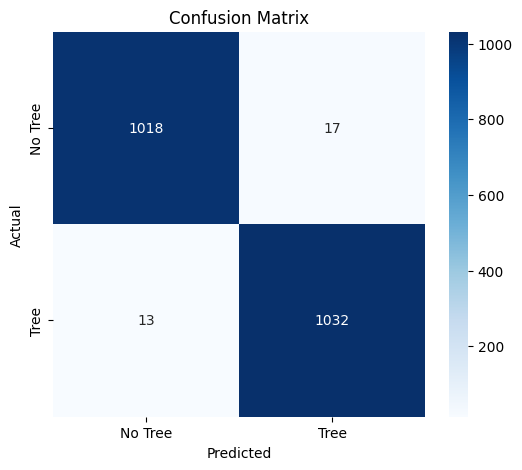

Classification Report:
               precision    recall  f1-score   support

     No Tree       0.99      0.98      0.99      1035
        Tree       0.98      0.99      0.99      1045

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080



In [13]:
# Collect predictions and true labels
y_true = []
y_pred = []

model.eval()

with torch.no_grad():
    for images, labels in val_loader:  # Using validation dataset
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tree", "Tree"], yticklabels=["No Tree", "Tree"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=["No Tree", "Tree"])
print("Classification Report:\n", class_report)


In [14]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a synthetic image tensor (1 image, 3 color channels, 224x224 resolution)
synthetic_image = torch.randn(1, 3, 224, 224).to(device)

def measure_inference_time(model, model_name):
    model.to(device)
    model.eval()

    # Warm-up
    for _ in range(5):
        with torch.no_grad():
            _ = model(synthetic_image)

    # Measure actual inference time
    start_time = time.time()
    with torch.no_grad():
        _ = model(synthetic_image)
    end_time = time.time()

    inference_time = end_time - start_time
    print(f"{model_name} Inference Time: {inference_time:.6f} seconds")

# Load and test ResNet-18
resnet18_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18_model.fc = torch.nn.Linear(resnet18_model.fc.in_features, 2)
measure_inference_time(resnet18_model, "ResNet-18")

ResNet-18 Inference Time: 0.002892 seconds


In [ ]:
def get_model_size(model, model_name):
    torch.save(model.state_dict(), f"{model_name}.pth")
    size = os.path.getsize(f"{model_name}.pth") / 1024 / 1024  # Convert to MB
    os.remove(f"{model_name}.pth")
    print(f"{model_name} Size: {size:.2f} MB")

# Measure size of model
get_model_size(resnet18_model, "ResNet-18")

In [16]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Print the model architecture
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  